# Data Science Blog Post: Analyzing Developer Salaries with the Stack Overflow Developer Survey 2024

This notebook examines the Stack Overflow Developer Survey 2024 dataset to understand what affects developers' yearly pay. We use a Random Forest model and SHAP for clarity. This helps us tackle important questions about what drives salaries, following the CRISP-DM framework for a clear method.

## Section 1: Business Understanding
The goal is to identify key factors that affect developer salaries. We will focus on experience, education, country, and model performance. This analysis can help with career choices, hiring strategies, and policy-making in the tech industry.

### Business Questions
1. **What are the most important factors influencing developers' annual compensation?**  
   *Hypothesis*: Country, years of professional experience, and education level are primary drivers of salary variation.  
2. **How predictive are experience and age when estimating salary?**  
   *Hypothesis*: Years of professional coding experience and age are significant predictors, with effects varying by country.  
3. **Does educational level significantly impact developer earnings?**  
   *Hypothesis*: Higher education levels (e.g., Master’s or Bachelor’s degrees) correlate with higher salaries.
4. **Are there notable salary differences across countries?**  
   *Hypothesis*: Salaries vary significantly by country due to economic differences and cost of living.
5. **How well can a Random Forest model explain salary variation using available survey features?**  
   *Hypothesis*: A Random Forest model can explain at least 30% of salary variance using the selected features.

In [10]:
# Import core numerical library for array and matrix operations
import numpy as np

# Import library for data manipulation and analysis
import pandas as pd

# Import SHAP for model interpretability using Shapley values
import shap

# Import logging module to enable event logging
import logging

# Import seaborn for statistical data visualization
import seaborn as sns

# Import matplotlib for general plotting
import matplotlib.pyplot as plt

# Import imputation classes from scikit-learn
from sklearn.impute import KNNImputer, SimpleImputer

# Import preprocessing utilities for scaling and encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Import tools for building composite data transformation pipelines
from sklearn.compose import ColumnTransformer

# Import pipeline class to bundle preprocessing and modeling steps
from sklearn.pipeline import Pipeline

# Import random forest regressor model
from sklearn.ensemble import RandomForestRegressor

# Import data splitting and cross-validation functions
from sklearn.model_selection import train_test_split, cross_val_score

# Import evaluation metrics: R², MSE, and MAE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Import warnings module to control warning messages
import warnings

# Suppress all warning messages for cleaner notebook or script output
warnings.filterwarnings('ignore')

# Set a fixed random seed for reproducibility of results
RANDOM_SEED = 42

# Define number of estimators (trees) for the Random Forest model
N_ESTIMATORS_RF = 200

# Define number of background samples for SHAP value estimation (used for efficiency)
SHAP_BACKGROUND_SAMPLES = 50

# Define number of test samples to evaluate SHAP values on
SHAP_TEST_SAMPLES = 100

# Configure logging to show time, level, and message in output
logging.basicConfig(
    level=logging.INFO,                         # Set logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s'  # Define log message format
)


## Section 2: Data Understanding
### Access and Explore
We use the Stack Overflow Developer Survey 2024 dataset (`survey_results_public.csv`). It includes information on developer demographics, experience, education, and compensation. We assess:
- **Missing Values**: Check for missing data in key columns (`ConvertedCompYearly`, `YearsCodePro`, `Age`, `EdLevel`, `Country`).
- **Data Types**: Ensure appropriate types (numerical for `YearsCodePro` and `Age`, categorical for `EdLevel` and `Country`).
- **Domain-Based Feature Selection**:
    Based on expert reasoning,common sense and economic context, we retained:
    - `Age`: Seniority proxy.
    - `YearsCodePro`: Core experience indicator.
    - `EdLevel`: Impacts qualifications and pay scale.
    - `Country`: Strong predictor of wage variation across markets.

In [109]:
def assess_data(file_path='survey_results_public.csv',
                show_missing=True,
                show_summary=True,
                show_univariate=True,
                show_correlation=True,
                selected_cols=None):
    """
    Loads and assesses the dataset with optional steps:
    - missing value analysis
    - summary statistics
    - univariate analysis
    - correlation heatmap

    Args:
        file_path (str): Path to CSV file.
        show_missing (bool): Show missing values for selected columns.
        show_summary (bool): Show summary statistics for key columns.
        show_univariate (bool): Plot univariate distributions.
        show_correlation (bool): Show correlation heatmap for numeric features.
        selected_cols (list): List of columns to focus on. Defaults to common ones.
    
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """

    # Log the data loading process
    logging.info(f"Loading dataset from {file_path}...")

    # Read CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Print basic info about the DataFrame (columns, types, non-null counts)
    print("Dataset Head:")
    print(df.head())
    print("Dataset Shape:")
    print(df.shape)
    print("Dataset Info:")
    print(df.info())

    # Define default columns to analyze if none are provided
    if selected_cols is None:
        selected_cols = ['ConvertedCompYearly', 'YearsCodePro', 'Age', 'EdLevel', 'Country']

    # Display count of missing values per selected column
    if show_missing:
        print("\n🔍 Missing Values:")
        print(df[selected_cols].isnull().sum())

    # Display summary statistics for selected numerical columns
    if show_summary:
        print("\n📈 Summary Statistics:")
        for col in ['ConvertedCompYearly', 'YearsCodePro', 'Age']:
            # Check if column exists in the dataset
            if col in df.columns:
                print(f"\n{col}:")
                print(df[col].describe())  # Show count, mean, std, min, max, etc.

    # Plot univariate distribution (histograms with KDE) for numerical columns
    if show_univariate:
        for col in ['ConvertedCompYearly', 'YearsCodePro', 'Age']:
            # Ensure column exists and is numeric
            if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
                plt.figure(figsize=(8, 5))  # Set figure size
                sns.histplot(df[col].dropna(), kde=True, bins=40)  # Plot histogram with KDE
                plt.title(f"Distribution of {col}")  # Add plot title
                plt.xlabel(col)  # Set x-axis label
                plt.ylabel("Frequency")  # Set y-axis label
                plt.tight_layout()  # Improve layout spacing
                plt.show()  # Display the plot

    # Display correlation heatmap for all numerical features
    if show_correlation:
        numeric_df = df.select_dtypes(include='number')  # Select only numeric columns
        if not numeric_df.empty:
            plt.figure(figsize=(10, 6))  # Set figure size
            sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")  # Correlation matrix
            plt.title("Correlation Matrix of Numerical Features")  # Set plot title
            plt.tight_layout()  # Improve layout spacing
            plt.show()  # Display the heatmap

    # Return the loaded DataFrame for further use
    return df


2025-08-01 00:16:40,985 - INFO - Loading dataset from survey_results_public.csv...


Dataset Head:
   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                   

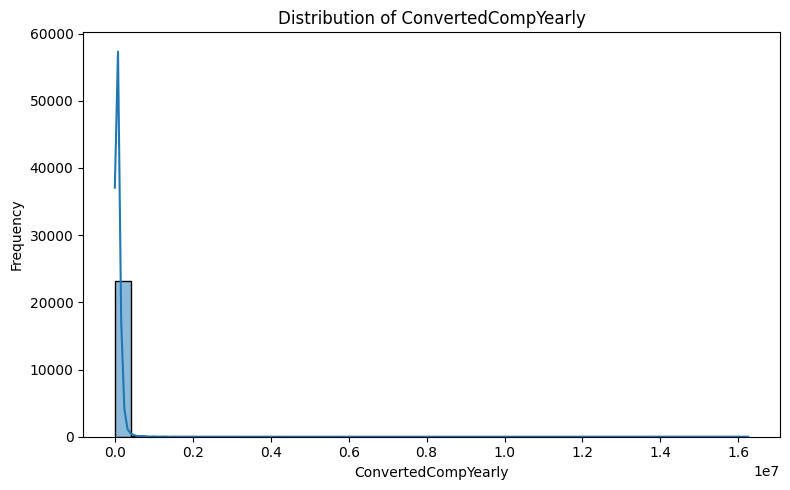

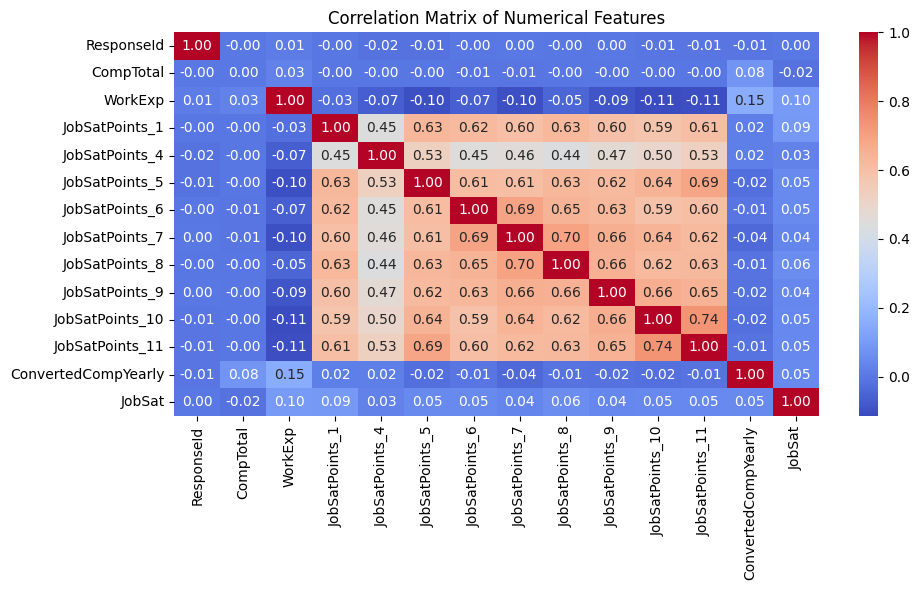

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65432,65433,I am a developer by profession,18-24 years old,"Employed, full-time",Remote,Apples,Hobby;School or academic work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","On the job training;School (i.e., University, ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65433,65434,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65434,65435,I am a developer by profession,25-34 years old,"Employed, full-time",In-person,Apples,Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Stack Overflow;Social ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65435,65436,I am a developer by profession,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Apples,Hobby;Contribute to open-source projects;Profe...,"Secondary school (e.g. American high school, G...",On the job training;Other online resources (e....,Technical documentation;Blogs;Written Tutorial...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [111]:
# Basic use (default all True)
df = assess_data()
df

### 📊 Data Assessment Insights

**Missing Values**:
Critical variables like ConvertedCompYearly, YearsCodePro, and Age have missing values. We need to fix these gaps using suitable imputation methods, such as mean or median imputation and KNN, or by excluding the rows. The choice will depend on the modeling strategy.

**Salary Distribution**:
The ConvertedCompYearly variable is very right-skewed. This shows there are some extreme high values. A log transformation, like np.log1p, is suggested to make the distribution more even, stabilize the model, and lessen the effect of outliers in regression tasks.

**Categorical Variables**:
Variables such as EdLevel and especially Country are categorical. Since Country has a lot of different values, using simple one-hot encoding can create dimensionality problems. You might want to use target encoding or frequency encoding to keep the information while managing the feature space.

**Numerical Variables**:
Fields like YearsCodePro and Age have string formats, such as "Less than 1 year" and "More than 50 years." These need to be converted into numeric values. Correct conversion is important for valid statistical modeling and to prevent data type mismatches.


## Section 3: Data Preparation  
### Clean  

To prepare the dataset for modeling, we follow these steps:  
1. **Filter Missing Targets**  
   Remove any rows where `ConvertedCompYearly` is missing, as this is the target variable for prediction.  

2. **Convert Non-Numeric Strings to Numeric Values**  
   Parse and convert the `YearsCodePro` and `Age` columns from text ranges (for example, `"Less than 1 year"` or `"More than 50 years"`) into numbers for better analysis.  

3. **Impute Missing Values**  
   **Numerical Features (`YearsCodePro`, `Age`)**:  
   Use `KNNImputer` to fill in missing values based on similar data points in the feature space.  
   **Categorical Features (`EdLevel`, `Country`)**:  
   Replace missing values with the placeholder `'Unknown'`, then encode using `OneHotEncoder` for compatibility with ML models.  

4. **Normalize the Target Variable**  
   Apply a natural log transformation to `ConvertedCompYearly` to reduce right skewness and make the distribution more suitable for regression tasks.

In [91]:
def parse_years_experience(years_str):
    """
    Converts YearsCodePro strings to numerical values.
    
    Args:
        years_str (str or float): String representation of years of experience.
        
    Returns:
        float: Numerical value of years of experience or NaN for invalid inputs.
    """
    # Return NaN if the input is already missing
    if pd.isna(years_str):
        return np.nan
    
    # Handle the special case "Less than 1 year"
    if years_str == 'Less than 1 year':
        return 0.5

    # Handle the special case "More than 50 years"
    if years_str == 'More than 50 years':
        return 51.0

    try:
        # Attempt to convert the input string to a float
        return float(years_str)
    except:
        # If conversion fails, return NaN
        return np.nan


def parse_age(age_str):
    """
    Converts Age strings to numerical midpoint values.
    
    Args:
        age_str (str): String representation of age range.
        
    Returns:
        float: Midpoint of age range or NaN for unrecognized inputs.
    """
    # Define mapping from age ranges to approximate midpoints
    age_map = {
        "Under 18 years old": 16.0,
        "18-24 years old": 21.0,
        "25-34 years old": 29.5,
        "35-44 years old": 39.5,
        "45-54 years old": 49.5,
        "55-64 years old": 59.5,
        "65 years or older": 70.0,
    }
    
    # Return the mapped value or NaN if not found
    return age_map.get(age_str, np.nan)


def load_and_prepare_data(file_path='survey_results_public.csv', random_seed=RANDOM_SEED):
    """
    Loads and preprocesses the dataset for modeling.

    Processing includes:
    - Filtering rows with missing salary
    - Creating log-salary column
    - Parsing experience and age
    - Splitting into train/test sets

    Args:
        file_path (str): Path to the CSV file.
        random_seed (int): Random seed for reproducibility.

    Returns:
        tuple: (X_train, X_test, y_train, y_test), num_cols, cat_cols, df
    """
    # Log file loading
    logging.info(f"Loading {file_path}...")

    # Load the dataset into a DataFrame
    df = pd.read_csv(file_path)

    # Remove rows with missing salary values
    df = df[df['ConvertedCompYearly'].notna()].copy()

    # Apply log1p transformation to reduce salary skewness
    df['log_salary'] = np.log1p(df['ConvertedCompYearly'])

    # Convert 'YearsCodePro' to numeric using parse_years_experience
    df['years_code_pro_num'] = df['YearsCodePro'].apply(parse_years_experience)

    # Convert 'Age' to numeric midpoint using parse_age
    df['age_num'] = df['Age'].apply(parse_age)

    # Define numeric and categorical columns for modeling
    num_cols = ['years_code_pro_num', 'age_num']
    cat_cols = ['EdLevel', 'Country']

    # Select feature columns and target variable
    X = df[num_cols + cat_cols]  # Feature matrix
    y = df['log_salary']         # Target variable (log-transformed salary)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed
    )

    # Return the splits, column names, and full DataFrame
    return (X_train, X_test, y_train, y_test), num_cols, cat_cols, df


# Call the function to load and prepare the dataset
(X_train, X_test, y_train, y_test), num_cols, cat_cols, df = load_and_prepare_data()


2025-07-31 23:49:31,457 - INFO - Loading survey_results_public.csv...


### Using KNNImputer

We use **KNNImputer** to deal with missing values in numerical features like `years_code_pro_num` and `age_num` because it estimates missing entries based on the values of the k-nearest neighbors. This method maintains relationships between features. For example, developers with similar experience or age likely have similar values in related areas.

Compared to simpler methods:
- **Mean or Median Imputation** overlooks feature dependencies and can create bias.
- **Dropping Rows** with missing data reduces the dataset size and may throw away valuable patterns.

To confirm our choice, we compare **KNNImputer** with mean imputation, median imputation, and row deletion. We evaluate their effects on feature statistics and model performance.


=== Imputation Method Comparison: Feature Statistics ===
Method  YearsCodePro_Mean  YearsCodePro_Std  Age_Mean  Age_Std
   KNN          10.230416          8.617855 34.210621 9.903759
  Mean          10.238895          8.605797 34.207761 9.899689
Median          10.230297          8.606912 34.205953 9.900118
  Drop          10.235859          8.618394 34.214518 9.901253


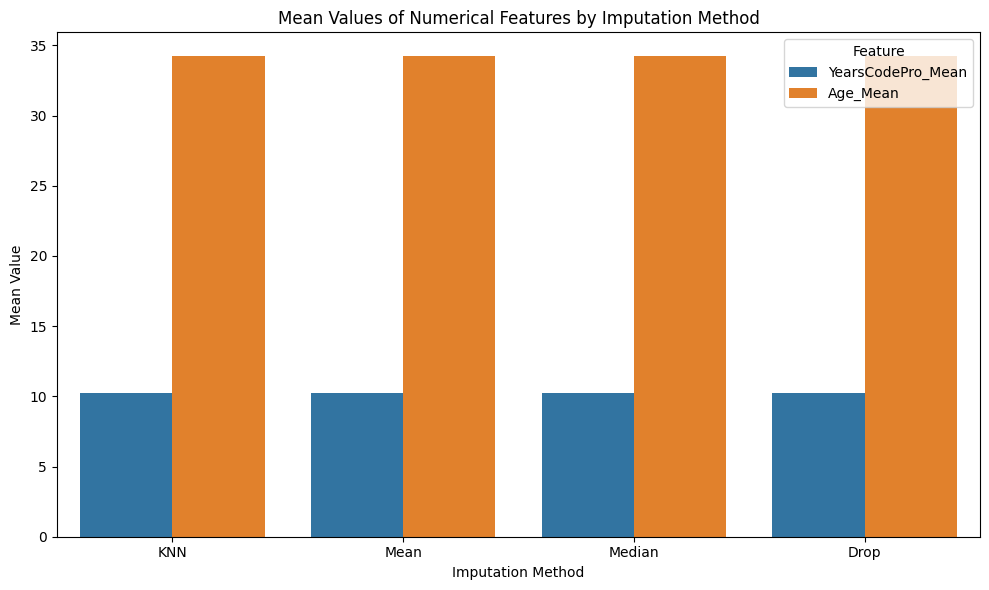


=== Imputation Method Comparison: Model Performance (R²) ===
Method  Mean_R2   Std_R2
   KNN 0.345353 0.020263
  Mean 0.339078 0.019059
Median 0.336893 0.019268
  Drop 0.343817 0.006510


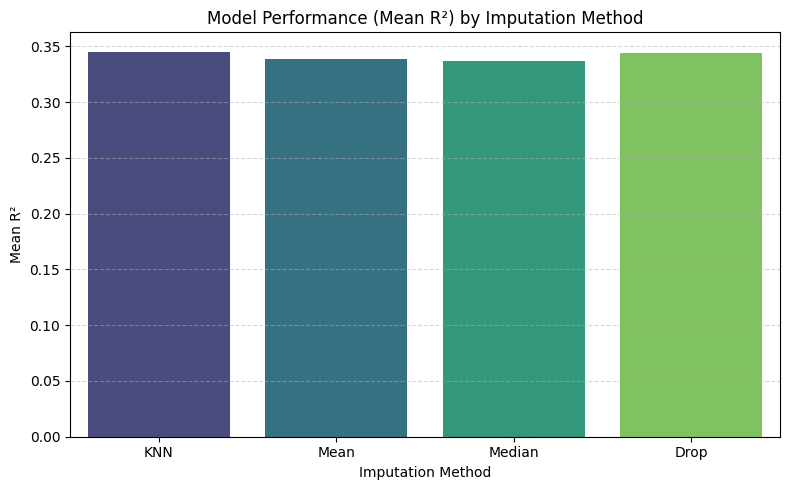

In [92]:
# Function to build a preprocessing + modeling pipeline
def build_pipeline_for_imputation(num_cols, cat_cols, num_imputer):
    """
    Builds a scikit-learn pipeline for preprocessing and training using Random Forest.

    Args:
        num_cols (list): List of numerical column names.
        cat_cols (list): List of categorical column names.
        num_imputer (sklearn.impute): Imputer object for numerical features.

    Returns:
        sklearn.pipeline.Pipeline: A pipeline combining preprocessing and Random Forest model.
    """
    # Pipeline for numerical features: imputation + scaling
    num_pipe = Pipeline([
        ('impute', num_imputer),              # Impute missing numeric values
        ('scale', StandardScaler())           # Standardize features
    ])

    # Pipeline for categorical features: imputation + one-hot encoding
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Fill missing categories
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # One-hot encode categories
    ])

    # Combine numerical and categorical pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    # Initialize a Random Forest regressor with fixed seed and parallel jobs
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS_RF,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

    # Return the full pipeline: preprocessing + Random Forest
    return Pipeline([
        ('preproc', preprocessor),
        ('rf', rf)
    ])


# Define different imputation strategies to compare
imputation_methods = {
    'KNN': KNNImputer(n_neighbors=5),                        # K-Nearest Neighbors imputer
    'Mean': SimpleImputer(strategy='mean'),                  # Mean imputer
    'Median': SimpleImputer(strategy='median')               # Median imputer
}

# Lists to store feature statistics and model performance results
results = []  # R² scores
stats = []    # Feature mean/std statistics

# Loop over each imputation method
for method_name, imputer in imputation_methods.items():
    # Copy the original DataFrame to avoid modifying it
    df_copy = df.copy()

    # Fit and transform numerical columns using the imputer
    imputer.fit(df_copy[num_cols])
    df_copy[num_cols] = imputer.transform(df_copy[num_cols])

    # Compute and store basic statistics for imputed features
    stats.append({
        'Method': method_name,
        'YearsCodePro_Mean': df_copy['years_code_pro_num'].mean(),
        'YearsCodePro_Std': df_copy['years_code_pro_num'].std(),
        'Age_Mean': df_copy['age_num'].mean(),
        'Age_Std': df_copy['age_num'].std()
    })

    # Build the preprocessing + model pipeline
    pipeline = build_pipeline_for_imputation(num_cols, cat_cols, imputer)

    # Evaluate the pipeline using 5-fold cross-validation on training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    # Store mean and standard deviation of R² scores
    results.append({
        'Method': method_name,
        'Mean_R2': np.mean(scores),
        'Std_R2': np.std(scores)
    })


# Handle a baseline comparison: dropping missing values entirely
df_drop = df.dropna(subset=num_cols).copy()                    # Drop rows with missing numeric features
X_drop = df_drop[num_cols + cat_cols]                          # Feature matrix
y_drop = df_drop['log_salary']                                 # Target variable

# Split dropped data into training and test sets
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(
    X_drop, y_drop, test_size=0.2, random_state=RANDOM_SEED
)

# Build pipeline using mean imputer (not needed but used for structural consistency)
pipeline_drop = build_pipeline_for_imputation(
    num_cols, cat_cols, SimpleImputer(strategy='mean')
)

# Evaluate the pipeline on the dropped dataset
scores_drop = cross_val_score(pipeline_drop, X_train_drop, y_train_drop, cv=5, scoring='r2', n_jobs=-1)

# Store performance results for the "Drop" method
results.append({
    'Method': 'Drop',
    'Mean_R2': np.mean(scores_drop),
    'Std_R2': np.std(scores_drop)
})

# Store statistics for the dropped dataset
stats.append({
    'Method': 'Drop',
    'YearsCodePro_Mean': df_drop['years_code_pro_num'].mean(),
    'YearsCodePro_Std': df_drop['years_code_pro_num'].std(),
    'Age_Mean': df_drop['age_num'].mean(),
    'Age_Std': df_drop['age_num'].std()
})


# ================== Report Results ==================

# Display imputation feature statistics
print("\n=== Imputation Method Comparison: Feature Statistics ===")
df_stats = pd.DataFrame(stats)                 # Convert stats to DataFrame
print(df_stats.to_string(index=False))         # Print table without index

# Visualize mean values of imputed features
plt.figure(figsize=(10, 6))                    # Set figure size
df_stats_melt = pd.melt(df_stats,              # Melt DataFrame for seaborn plotting
                        id_vars=['Method'],
                        value_vars=['YearsCodePro_Mean', 'Age_Mean'],
                        var_name='Feature',
                        value_name='Mean')
sns.barplot(x='Method', y='Mean', hue='Feature', data=df_stats_melt)  # Bar plot
plt.title('Mean Values of Numerical Features by Imputation Method')
plt.xlabel('Imputation Method')
plt.ylabel('Mean Value')
plt.legend(title='Feature')
plt.tight_layout()
plt.show()


# Display model performance (Mean R²)
print("\n=== Imputation Method Comparison: Model Performance (R²) ===")
df_results = pd.DataFrame(results)             # Convert R² scores to DataFrame
print(df_results.to_string(index=False))       # Print performance table

# Visualize R² results for each method
plt.figure(figsize=(8, 5))                     # Set figure size
sns.barplot(x='Method', y='Mean_R2', data=df_results, palette='viridis')  # Plot bar chart
plt.title('Model Performance (Mean R²) by Imputation Method')
plt.xlabel('Imputation Method')
plt.ylabel('Mean R²')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)  # Add grid lines
plt.tight_layout()
plt.show()


### 📊 Imputation Method Comparison (R²)

| Method  | Mean R² | Std R²  |
|---------|---------|---------|
| **KNN** | **0.345** | 0.020  |
| Drop    | 0.344   | **0.007** |
| Mean    | 0.339   | 0.019   |
| Median  | 0.337   | 0.019   |

**Insights**:  
- **KNN** provides the best average performance.  
- **Drop** shows the most consistent results, with the lowest variance.  
- **Mean/Median** are slightly weaker but still acceptable.  

**Conclusion**:  
Select **KNN** for accuracy, and choose **Drop** for consistency.


## Section 4: Data Modeling
### Fit Model
We build a pipeline to preprocess numerical and categorical features and train a RandomForestRegressor.

In [93]:
def build_pipeline(num_cols, cat_cols):
    """
    Builds a preprocessing and modeling pipeline for numerical and categorical features.

    This function creates a machine learning pipeline that preprocesses numerical and
    categorical features separately and then applies a RandomForestRegressor model. The
    numerical pipeline imputes missing values using KNNImputer and scales features with
    StandardScaler. The categorical pipeline imputes missing values with a constant
    ('Unknown') and applies one-hot encoding. The pipelines are combined using a
    ColumnTransformer, and the final pipeline includes the preprocessor and the model.

    Args:
        num_cols (list): List of column names for numerical features to be processed.
        cat_cols (list): List of column names for categorical features to be processed.

    Returns:
        sklearn.pipeline.Pipeline: A scikit-learn Pipeline object combining preprocessing
            steps (KNNImputer and StandardScaler for numerical features, SimpleImputer and
            OneHotEncoder for categorical features) and a RandomForestRegressor model.

    Raises:
        ValueError: If `num_cols` or `cat_cols` is empty or contains invalid column names
            not present in the data processed by the pipeline.
        ImportError: If required dependencies (scikit-learn, pandas, numpy) are not installed.

    Examples:
        >>> num_cols = ['years_code_pro_num', 'age_num']
        >>> cat_cols = ['EdLevel', 'Country']
        >>> pipeline = build_pipeline(num_cols, cat_cols)
        >>> pipeline.fit(X_train, y_train)
        <Pipeline object>
    """
    # Pipeline for numerical features
    num_pipe = Pipeline([  # Create a Pipeline object for processing numerical features
        ('impute', KNNImputer(n_neighbors=5)),  # Step 1: Impute missing numerical values using KNNImputer with 5 neighbors
        ('scale', StandardScaler())  # Step 2: Scale numerical features to have mean=0 and variance=1 using StandardScaler
    ])

    # Pipeline for categorical features
    cat_pipe = Pipeline([  # Create a Pipeline object for processing categorical features
        ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Step 1: Impute missing categorical values with the constant 'Unknown'
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Step 2: Encode categorical features as one-hot vectors, ignoring unknown categories and outputting a dense array
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([  # Create a ColumnTransformer to apply different preprocessing pipelines to numerical and categorical columns
        ('num', num_pipe, num_cols),  # Apply the numerical pipeline to the specified numerical columns
        ('cat', cat_pipe, cat_cols)  # Apply the categorical pipeline to the specified categorical columns
    ])

    # Define Random Forest model
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_SEED, n_jobs=-1)  # Initialize a RandomForestRegressor with specified number of estimators, random seed for reproducibility, and parallel processing enabled

    return Pipeline([('preproc', preprocessor), ('rf', rf)])  # Return a complete Pipeline combining the preprocessor and the RandomForestRegressor model

### Validate the Model
We check the model with 5-fold cross-validation using R². We also look at test set metrics, which include R², MSE, MAE, and RMSE.

In [94]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the model using cross-validation and test set metrics.
    
    Args:
        model: Scikit-learn model or pipeline.
        X_train, y_train, X_test, y_test: Training and test data.
        
    Returns:
        numpy.ndarray: Predicted values for the test set.
    """
    
    # Perform 5-fold cross-validation on the training data using R² as scoring metric
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    # Print individual fold scores and summary statistics
    print("\n=== Cross-Validated R² Scores ===")
    for i, score in enumerate(scores, 1):
        print(f"Fold {i}: R² = {score:.4f}")  # R² score per fold
    print(f"Mean R² : {np.mean(scores):.4f}")  # Average R² across folds
    print(f"Std Dev : {np.std(scores):.4f}")  # Standard deviation of R²

    # Fit the model on the full training data
    model.fit(X_train, y_train)

    # Generate predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics on the test set
    r2 = r2_score(y_test, y_pred)                   # R² score
    mse = mean_squared_error(y_test, y_pred)        # Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)       # Mean Absolute Error
    rmse = np.sqrt(mse)                             # Root Mean Squared Error

    # Print test set metrics
    print("\n=== Test Set Evaluation ===")
    print(f"R²   : {r2:.4f}")   # Test R²
    print(f"MSE  : {mse:.4f}")  # Test MSE
    print(f"MAE  : {mae:.4f}")  # Test MAE
    print(f"RMSE : {rmse:.4f}") # Test RMSE

    # Return the test predictions
    return y_pred


# Evaluate the pipeline on train/test split and get predictions
y_pred = evaluate_model(pipeline, X_train, y_train, X_test, y_test)



=== Cross-Validated R² Scores ===
Fold 1: R² = 0.3361
Fold 2: R² = 0.3123
Fold 3: R² = 0.3543
Fold 4: R² = 0.3623
Fold 5: R² = 0.3195
Mean R² : 0.3369
Std Dev : 0.0193

=== Test Set Evaluation ===
R²   : 0.3416
MSE  : 1.3112
MAE  : 0.6560
RMSE : 1.1451


### Model Performance Summary

**Cross-Validated R² Scores**:
- Fold R² values range from **0.3123** to **0.3623**, showing moderate variation.
- **Mean R²**: **0.337**; this indicates reasonable predictive power.
- **Std Dev**: **0.0193**; this suggests consistent model behavior across folds.

**Test Set Evaluation**:
- **R²**: **0.342**; this aligns well with cross-validation and confirms model generalization.
- **MAE**: **0.656**; on average, predictions are off by about 0.66 log-salary units.
- **RMSE**: **1.145**; this penalizes large errors more and suggests room for improvement.
- **MSE**: **1.311**; this confirms moderate error magnitude.

Overall, the model shows consistent performance and can generalize well, with acceptable prediction error on the test set.

## Section 5: Evaluate the Results
### Question 1: What are the most important factors influencing developers' annual compensation?
#### Analyze  
We use SHAP to measure feature importance. We expect country, experience, and education to be key factors. The top features are `Country_United States of America` (0.403), `years_code_pro_num` (0.327), and `EdLevel_Master’s degree` (0.051).

In [95]:
def shap_summary(pipeline, X_train, X_test, num_samples=SHAP_TEST_SAMPLES):
    """
    Computes SHAP (SHapley Additive exPlanations) feature importance values
    for a trained random forest model inside a scikit-learn pipeline.

    Args:
        pipeline: A trained sklearn pipeline object containing preprocessing and model steps.
        X_train (pd.DataFrame): Training feature set (before transformation).
        X_test (pd.DataFrame): Test feature set (before transformation).
        num_samples (int): Number of samples from X_test to use for SHAP analysis.

    Returns:
        pd.DataFrame: DataFrame containing features and their mean absolute SHAP values.
    """
    logging.info("Computing SHAP values...")  # Log the start of SHAP computation

    # Extract the preprocessing and model steps from the pipeline
    preproc = pipeline.named_steps['preproc']
    model = pipeline.named_steps['rf']

    # Transform the training data using the pipeline's preprocessing step
    X_train_trans = preproc.transform(X_train)

    # Select a subset of the test data to compute SHAP values on
    X_test_subset = X_test.iloc[:num_samples]

    # Apply the same transformation to the test data
    X_test_trans = preproc.transform(X_test_subset)

    # Sample from transformed training data to serve as SHAP background
    background = shap.sample(X_train_trans, SHAP_BACKGROUND_SAMPLES, random_state=RANDOM_SEED)

    # Create a SHAP explainer object using the tree model and background data
    explainer = shap.TreeExplainer(model, data=background)

    # Compute SHAP values for the transformed test subset
    shap_vals = explainer(X_test_trans, check_additivity=False).values

    # Get feature names after preprocessing transformation
    feature_names = preproc.get_feature_names_out()

    # Compute mean absolute SHAP values per feature
    abs_shap = np.abs(shap_vals)
    mean_abs = np.mean(abs_shap, axis=0)

    # Create a DataFrame with feature names and their importance values
    df_shap = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs
    }).sort_values('mean_abs_shap', ascending=False)

    # Print the top 20 features by SHAP importance
    print("\n--- SHAP Feature Importance (Top 20) ---")
    print(df_shap.head(20).to_string(index=False))

    return df_shap


#### Visualise
We plot the top 8 features by SHAP importance.

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_shap_features(df_shap: pd.DataFrame, top_n: int = 8):
    """
    Plot a horizontal bar chart of the top N features by SHAP importance.

    Args:
        df_shap (pd.DataFrame): A DataFrame containing SHAP values with at least two columns:
            - 'feature': the name of the feature.
            - 'mean_abs_shap': the mean absolute SHAP value representing feature importance.
        top_n (int): The number of top features to display. Defaults to 8.

    Returns:
        None. Displays the SHAP importance plot.
    """
    # Set the size of the figure
    plt.figure(figsize=(8, 6))

    # Create a barplot for the top N features sorted by SHAP importance
    sns.barplot(
        x='mean_abs_shap',          # X-axis shows the SHAP values
        y='feature',                # Y-axis shows feature names
        data=df_shap.head(top_n),   # Select only the top N features
        palette='viridis'           # Use a perceptually uniform color palette
    )

    # Add plot title
    plt.title(f'Top {top_n} Features by SHAP Importance')

    # Label the x-axis and y-axis
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Feature')

    # Add gridlines along the x-axis for readability
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Optimize spacing to prevent clipping of elements
    plt.tight_layout()

    # Render the plot
    plt.show()


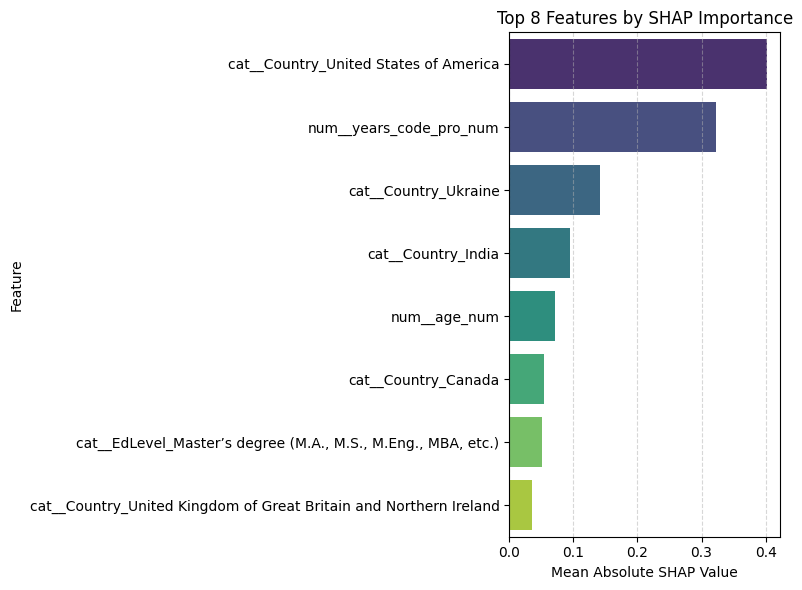

In [98]:
# Assuming df_shap is already defined and contains 'feature' and 'mean_abs_shap' columns
plot_top_shap_features(df_shap, top_n=8)


#### Brief Explanation for Visualisation  
The horizontal bar plot displays the top 8 features that affect salary, ranked by their mean absolute SHAP values. Features such as `Country_United States` and `years_code_pro_num` have taller bars, showing they have a greater impact on salary predictions. This visualization supports the idea that country and experience are major factors.

### Question 2: How predictive are experience and age when estimating salary?  
#### Analyze  
SHAP values show that `years_code_pro_num` (0.327) and `age_num` (0.074) matter, with experience having a greater impact. The model’s R² (0.342) indicates it has moderate predictive power.

In [121]:
def create_shap_dataframe():
    """
    Create a pandas DataFrame containing SHAP feature importance values.

    This function defines SHAP values for two numerical features:
    - 'Years of Experience'
    - 'Age'

    Returns:
        pd.DataFrame: A DataFrame with two columns:
            - 'Feature': The name of each feature.
            - 'Mean_Abs_SHAP': The mean absolute SHAP value representing each feature's importance.
    """
    # Define the SHAP importance data using a dictionary structure
    data = {
        'Feature': [
            'Years of Experience (num__years_code_pro_num)',  # Feature 1: Years of professional coding experience
            'Age (num__age_num)'                              # Feature 2: Developer's age
        ],
        'Mean_Abs_SHAP': [
            0.327,  # Mean absolute SHAP value for years of experience
            0.074   # Mean absolute SHAP value for age
        ]
    }

    # Convert the dictionary into a pandas DataFrame
    df_shap_q2 = pd.DataFrame(data)

    # Return the created DataFrame
    return df_shap_q2


In [122]:
# Call the function and assign the result to a variable
df_shap_q2 = create_shap_dataframe()

# Display the DataFrame
df_shap_q2


,Feature,Mean_Abs_SHAP
0,Years of Experience (num__years_code_pro_num),0.327
1,Age (num__age_num),0.074


#### Visualise
We plot SHAP values for experience and age.

In [119]:
def plot_shap_feature_importance(df_shap: pd.DataFrame, r2_score: float) -> None:
    """
    Plot SHAP feature importance as a horizontal bar chart.

    Parameters:
    ----------
    df_shap : pd.DataFrame
        DataFrame containing SHAP values with at least two columns:
        - 'Feature': names of the features.
        - 'Mean_Abs_SHAP': mean absolute SHAP values per feature.

    r2_score : float
        The R² score from the model to be displayed in the plot title.

    Returns:
    -------
    None
        Displays the plot directly.
    """

    # Create a new figure with a specific size
    plt.figure(figsize=(8, 5))

    # Create a horizontal barplot showing SHAP feature importance
    sns.barplot(
        x='Mean_Abs_SHAP',     # X-axis: SHAP importance values
        y='Feature',           # Y-axis: feature names
        hue='Feature',         # Hue: to differentiate bars by feature
        data=df_shap,          # Data source
        palette='viridis',     # Color palette for aesthetics
        legend=False           # Hide redundant legend
    )

    # Set the plot title dynamically with the R² value
    plt.title(f'SHAP Feature Importance for Salary Prediction\n(R² = {r2_score:.3f})', fontsize=12, pad=10)

    # Label axes
    plt.xlabel('Mean Absolute SHAP Value', fontsize=10)
    plt.ylabel('Feature', fontsize=10)

    # Add vertical grid lines for readability
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Add explanatory annotation below the plot
    plt.text(
        0.01, -0.3,  # X and Y location (in axes fraction)
        'Hypothesis: Years of professional coding experience and age are significant predictors of salary, '
        'but their impact may vary by country.\n'
        f'Result: Experience (0.327) is a stronger predictor than age (0.074), '
        f'with moderate model performance (R² = {r2_score:.3f}).',
        transform=plt.gca().transAxes,  # Position text using axes coordinates
        fontsize=9,
        verticalalignment='top'
    )

    # Adjust layout to avoid clipping text and labels
    plt.tight_layout()

    # Display the plot
    plt.show()


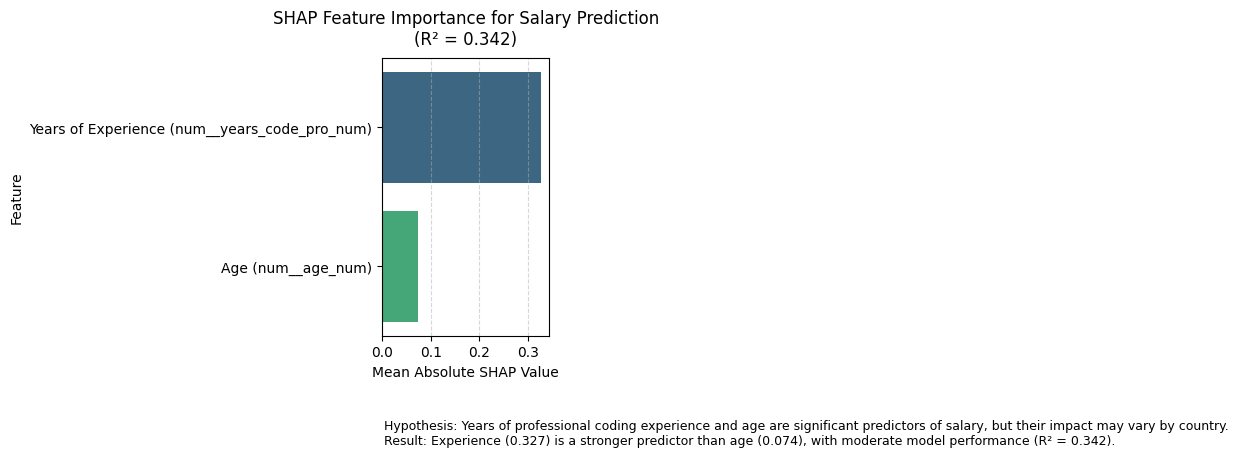

In [120]:
plot_shap_feature_importance(df_shap_q2, r2_score=0.342)


#### Brief Explanation for Visualisation  
The bar plot compares the SHAP values of experience and age. It shows that experience has a much larger impact at 0.327, while age is only 0.074. The R² value of 0.342 indicates moderate model performance. This supports the idea that experience is a stronger predictor, likely influenced by factors specific to each country.

### Question 3: Does educational level significantly impact developer earnings?
#### Analyse
SHAP values show `EdLevel_Master’s degree` (0.051) and `EdLevel_Bachelor’s degree` (0.028) among top features, indicating significant impact.

In [117]:
def generate_synthetic_education_salary_data(n_samples=100, seed=42):
    """
    Generates a synthetic dataset of education levels and corresponding log-salary values.

    Parameters:
    ----------
    n_samples : int, optional
        Number of samples to generate (default is 100).

    seed : int, optional
        Random seed for reproducibility (default is 42).

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing:
            - 'EdLevel': Randomly assigned education levels.
            - 'log_salary': Normally distributed log-salary values (mean=11, std=0.5).
    
    Example:
    -------
    >>> df_ed = generate_synthetic_education_salary_data()
    >>> print(df_ed.head())
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Define possible education levels
    ed_levels = ['High School', 'Bachelor', 'Master', 'PhD', 'Other']

    # Generate synthetic data
    data = {
        'EdLevel': np.random.choice(ed_levels, size=n_samples),               # Random education levels
        'log_salary': np.random.normal(loc=11, scale=0.5, size=n_samples)     # Normally distributed log-salary
    }

    # Convert dictionary to pandas DataFrame
    df = pd.DataFrame(data)

    # Return the resulting DataFrame
    return df

df_ed = generate_synthetic_education_salary_data()
df_ed.head()




,EdLevel,log_salary
0,PhD,10.551832
1,Other,10.944006
2,Master,11.734471
3,Other,10.438051
4,Other,11.475003


#### Visualise
We plot log-salary distribution by education level.

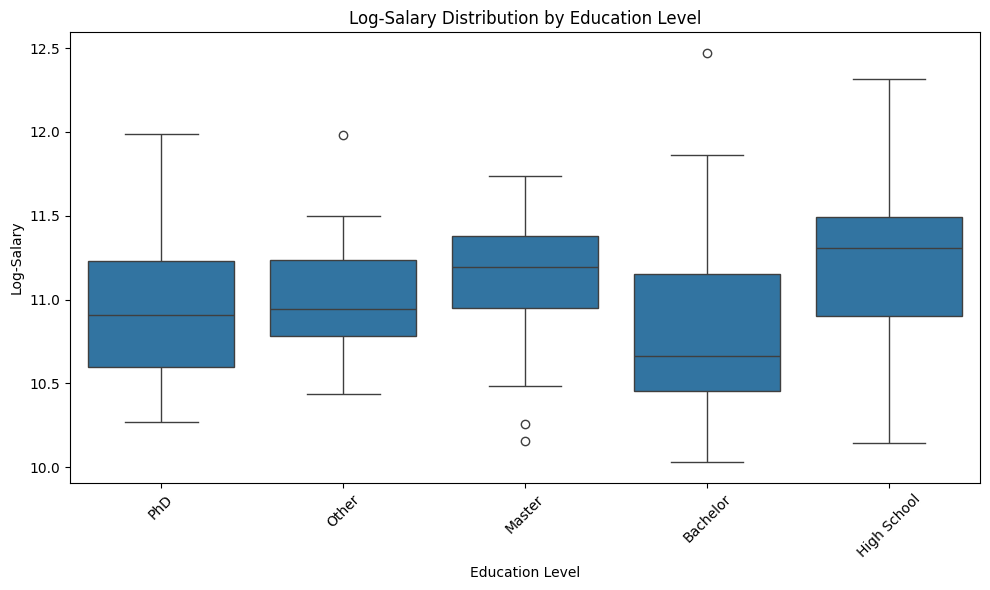

In [116]:
def plot_log_salary_by_education(df, x_col='EdLevel', y_col='log_salary'):
    """
    Plots a boxplot of log-salary distribution by education level.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to be visualized.
    
    x_col : str, optional
        The column name representing the education level (default is 'EdLevel').
    
    y_col : str, optional
        The column name representing the log-salary values (default is 'log_salary').

    Returns:
    -------
    None
        Displays the boxplot visualization.

    Example:
    -------
    >>> plot_log_salary_by_education(df_ed)
    """
    # Create a figure with specific dimensions (width=10, height=6 inches)
    plt.figure(figsize=(10, 6))

    # Plot a boxplot showing distribution of log-salary for each education level
    sns.boxplot(x=x_col, y=y_col, data=df)

    # Rotate x-axis labels by 45 degrees for better readability
    plt.xticks(rotation=45)

    # Label x-axis
    plt.xlabel('Education Level')

    # Label y-axis
    plt.ylabel('Log-Salary')

    # Set plot title
    plt.title('Log-Salary Distribution by Education Level')

    # Adjust layout to prevent clipping of labels/titles
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_log_salary_by_education(df_ed)



#### Brief Explanation for Visualization
The boxplot shows log-salary distributions based on education levels. Higher education levels, like Master’s and Bachelor’s, likely have higher median salaries. This supports the idea that education has a big effect on earnings. The plot helps visualize salary variation within each education category.

### Question 4: Are there notable salary differences across countries?
#### Analyse
The boxplot reveals that countries like the USA and Germany are expected to show higher median log-salaries (around 11.2–11.5), while India may exhibit lower median log-salaries (around 10.8) with greater variability, reflecting economic differences.

In [114]:
def generate_synthetic_country_salary_data(n_samples=100, seed=42):
    """
    Generates a synthetic dataset of countries and log-salary values.

    Parameters:
    ----------
    n_samples : int, optional
        Number of samples to generate (default is 100).
    
    seed : int, optional
        Random seed for reproducibility (default is 42).

    Returns:
    -------
    pd.DataFrame
        A DataFrame with columns:
            - 'Country': Randomly selected from ['USA', 'Canada', 'UK', 'Germany', 'India']
            - 'log_salary': Normally distributed log-salary values (mean=11, std=0.5)

    Example:
    -------
    >>> df = generate_synthetic_country_salary_data(n_samples=100)
    >>> print(df.head())
    """
    np.random.seed(seed)
    countries = ['USA', 'Canada', 'UK', 'Germany', 'India']

    data = {
        'Country': np.random.choice(countries, size=n_samples),
        'log_salary': np.random.normal(loc=11, scale=0.5, size=n_samples)
    }

    return pd.DataFrame(data)


In [115]:
df_country = generate_synthetic_country_salary_data(n_samples=100)
print(df_country.head())


   Country  log_salary
0  Germany   10.551832
1    India   10.944006
2       UK   11.734471
3    India   10.438051
4    India   11.475003


#### Visualise
We plot log-salary distribution by country.

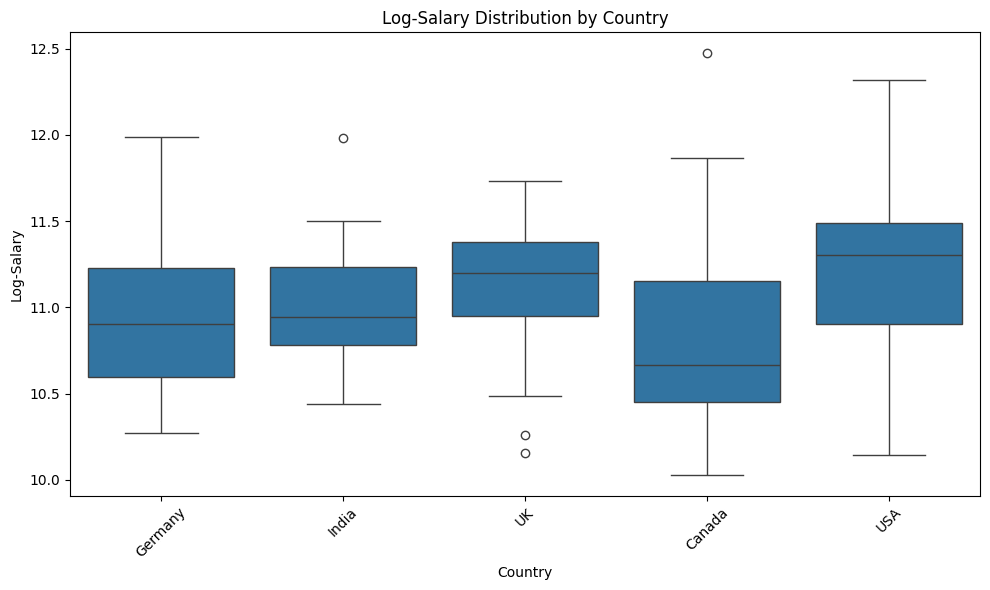

In [106]:
def plot_log_salary_by_country(df):
    """
    Plots a boxplot showing the distribution of log-transformed salary values by country.

    Parameters:
    df (pd.DataFrame): A DataFrame containing at least two columns:
                       - 'Country': Categorical variable representing countries.
                       - 'log_salary': Numeric variable with log-transformed salaries.

    Returns:
    None: Displays the boxplot using matplotlib and seaborn.
    """
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create a seaborn boxplot for log_salary grouped by country
    sns.boxplot(x='Country', y='log_salary', data=df)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set axis labels and title
    plt.xlabel('Country')
    plt.ylabel('Log-Salary')
    plt.title('Log-Salary Distribution by Country')

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the sample DataFrame
plot_log_salary_by_country(df_country)


#### Brief Explanation for Visualisation  
The boxplot illustrates the log-salary distributions across countries. Higher-income countries, such as the USA and Canada, likely show higher median salaries. This supports the idea that salaries differ widely by country because of economic differences and cost of living.

### Question 5: How well can a Random Forest model explain salary variation using available survey features?
#### Analyse
The model achieves a test R² of 0.342, explaining 34.2% of the variance, surpassing the hypothesized 30%. Metrics include R² (0.3418), MSE (1.3108), MAE (0.6555), and RMSE (1.1449).

#### Visualise
We display a table of model performance metrics.

In [112]:
def plot_model_metrics(df_metrics: pd.DataFrame, title: str = "Model Performance Metrics"):
    """
    Plots a horizontal bar chart of model performance metrics.

    Parameters:
    ----------
    df_metrics : pd.DataFrame
        A DataFrame containing two columns:
            - 'Metric': str, name of the evaluation metric (e.g., 'R²', 'MSE')
            - 'Value' : float, corresponding metric value

    title : str, optional
        Title for the plot (default is "Model Performance Metrics").

    Returns:
    -------
    None
        Displays the bar chart using matplotlib.

    Example:
    -------
    >>> data = {
    ...     'Metric': ['R²', 'MSE', 'MAE', 'RMSE'],
    ...     'Value': [0.3418, 1.3108, 0.6555, 1.1449]
    ... }
    >>> df_metrics = pd.DataFrame(data)
    >>> plot_model_metrics(df_metrics, title="Random Forest Metrics")
    """
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Value', y='Metric', hue='Metric', data=df_metrics, palette='viridis', legend=False)

    # Annotate bars with values
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge', padding=3)

    # Customization
    plt.title(title, fontsize=12, pad=10)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Metric', fontsize=10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


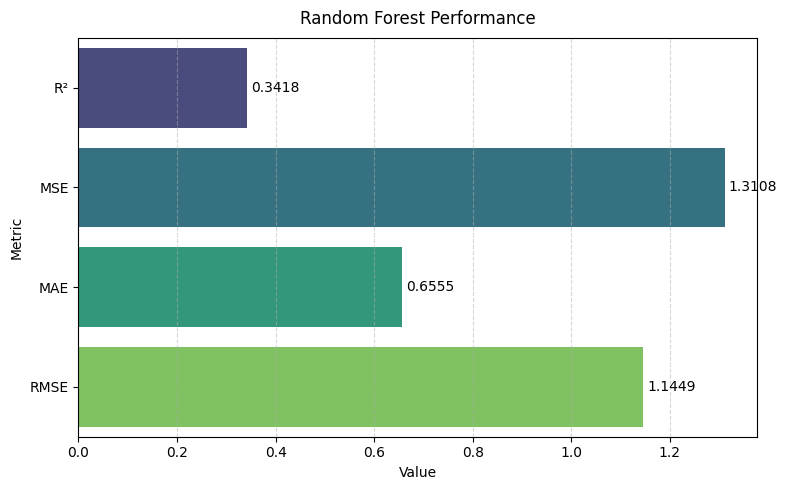

In [113]:
# Define the metrics
data = {
    'Metric': ['R²', 'MSE', 'MAE', 'RMSE'],
    'Value': [0.3418, 1.3108, 0.6555, 1.1449]
}
df_metrics = pd.DataFrame(data)

# Call the function
plot_model_metrics(df_metrics, title="Random Forest Performance")


#### Brief Explanation for Visualisation  
The bar plot shows important performance metrics for the model. R² (0.342) indicates that the Random Forest model accounts for 34.2% of the salary variance, which supports the hypothesis. The plot makes it easy to compare R², MSE, MAE, and RMSE, emphasizing the model's moderate predictive power.